# Libraries

In [1]:
# Numerical
## Basic
import pandas as pd
import numpy as np

## ML
from sklearn.cluster import KMeans

# Plotting
## Basic
import matplotlib.pyplot as plt
import matplotlib

plt.style.use('seaborn')

## Video
from matplotlib import animation
plt.rcParams['animation.ffmpeg_path'] = 'C:/Users/USer1/Documents/ffmpeg/bin/ffmpeg.exe'

## Geographical
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Other
from IPython.display import HTML, clear_output

# Basic Understanding
Since the dataset is small enough, we begin the analysis by importing it whole indo a pandas dataframe:

In [2]:
data = pd.read_csv('puzzle.csv', header=None)

In [3]:
print(f'Shape of Dataset: {data.shape}\n')
data.head()

Shape of Dataset: (1024, 2)



,0,1
0,0.39715,2.113629
1,0.39715,2.113629
2,0.39715,2.113629
3,0.39715,2.113629
4,0.39715,2.113629


The data is 2D so we can plot it for insights:

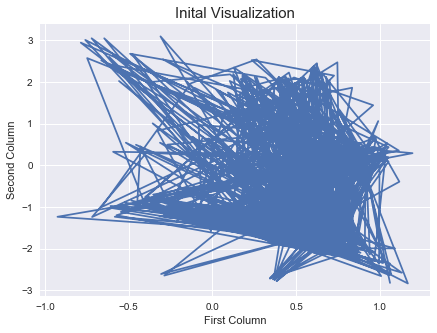

In [4]:
plt.figure(figsize=(7, 5))
plt.plot(data[0], data[1])
plt.title('Inital Visualization', size=15)
plt.xlabel('First Column')
plt.ylabel('Second Column')
plt.show()

From this quick viz, we can probably assume the data not to be a time-series. At least not a sorted one. We can try using a scatter plot instead.

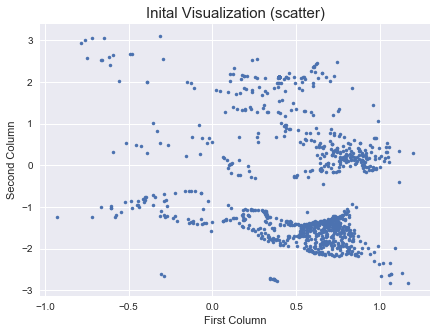

In [5]:
plt.figure(figsize=(7, 5))
plt.plot(data[0], data[1], '.')
plt.title('Inital Visualization (scatter)', size=15)
plt.xlabel('First Column')
plt.ylabel('Second Column')
plt.show()

From here, the first intuition is too see a potential clustering problem. Had we have tags, we might even build a simple classifier (multi-class linear would probably be sufficent) to separate all these clusters. The interpretation for such analysis would be quite poor, since there is no real context to the puzzle... Except that we know the data set to be from a travel related company... the scatter plot all of a sudden takes a whole new meaning if we see its transpose.

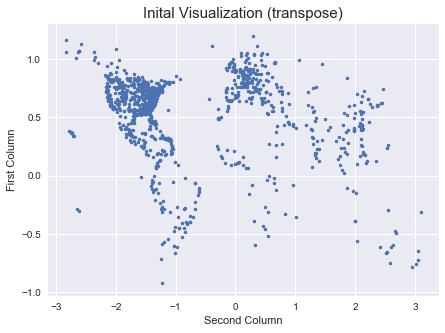

In [6]:
plt.figure(figsize=(7, 5))
plt.plot(data[1], data[0], '.')
plt.title('Inital Visualization (transpose)', size=15)
plt.xlabel('Second Column')
plt.ylabel('First Column')
plt.show()

The map clearly shows some geographical distribution and that the pairs of values represent coordinates in the globe in arbitrary units $(x, y)$. We will first rename the dataset columns for clarity.

In [7]:
data.columns = ['y', 'x']
data.head()

,y,x
0,0.39715,2.113629
1,0.39715,2.113629
2,0.39715,2.113629
3,0.39715,2.113629
4,0.39715,2.113629


# Geographical Understanding
Now, for more accurate plotting, we can convert our coordinate system into a more practical longitude-latitudes pair system.

An educated first guess would be that the conversion from arbitrary units (x, y) to Longitude and Latitude is linear. We can also probably assume (from visual inspection) at this first manual tagging that the origin $(0, 0)$ corresponds to the intersection point between the Equator and the Prime Meridian. As far as we know, these could be simply visited cities, airport coordinates, etc. It is probably safe to assume though that it is some type of "major" landmark. At least not simply the location of someone's favourite trees in each country.

The simplest approach to converting our units then is to find the smallest easily identifiable country and searching for longitude and latitude coordinates online. The smaller the country is, the more accurate the prediction will be since whether the coordinate indicates the city's airport or city center, our approximate search of Longitude and Latitude should be close enough.

For this, we then choose (what most likely is) the tiny island of **Bermuda** in the atlantic, off the coast of southeastern USA. We first find its coordinates in the raw coordinate system. We can get these by using a more interactive library such as plotly. We don't show it here to limit the one-use requiremnt of plotly. Together with the coordinates we get by googling *bermuda longitude latitude*: 

In [8]:
bermudaCoord = np.array((-1.128856, 0.5648583))
bermudaLonLat = np.array((-64.7505, 32.3078))

In [9]:
cols = ['Longitude', 'Latitude']
data[cols] = pd.DataFrame(data.apply(lambda row : bermudaLonLat/bermudaCoord*(row.x, row.y), axis=1).tolist(), columns=cols)
# data.to_csv('dataGeo.csv', index=False)

In [10]:
data.head()

,y,x,Longitude,Latitude
0,0.39715,2.113629,121.236463,22.71549
1,0.39715,2.113629,121.236463,22.71549
2,0.39715,2.113629,121.236463,22.71549
3,0.39715,2.113629,121.236463,22.71549
4,0.39715,2.113629,121.236463,22.71549


And now we can plot it on a world map for better reference:

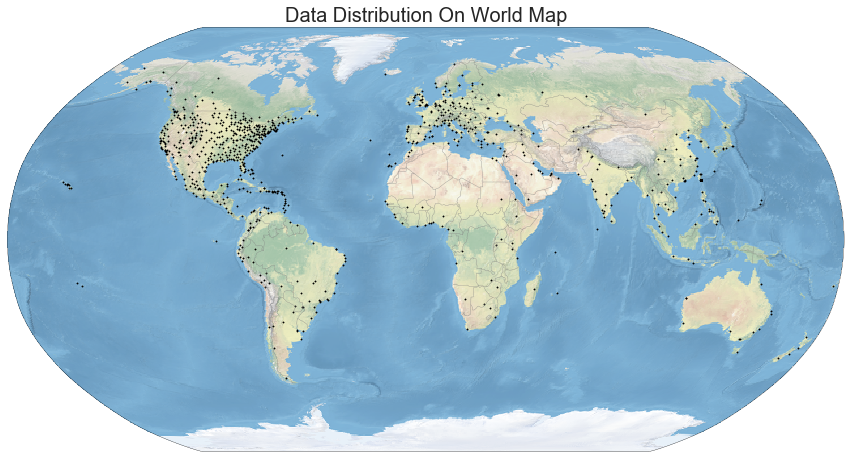

In [11]:
plt.figure(figsize=(15, 18))
ax = plt.axes(projection=ccrs.Robinson())
ax.stock_img()
# ax.coastlines();
borders = cfeature.BORDERS
ax.add_feature(borders, edgecolor='gray')

ax.scatter(data.Longitude, data.Latitude, transform=ccrs.PlateCarree(),
           c='black', s=2)
plt.title('Data distribution on World Map'.title(), size=20)

plt.show()

From the last plot alone, once could think that the dataset represents only a set of places on earth. However, from the head, of the datset, we see that some coordinates are repeated. This is a particularly important detail that would have had to be explored irrespective of the head of the dataset.

If all points would appear only once, then with no *a priori* information, we would have to assume that the dots were simply coordinates in space and their order didn't really matter. However, if this was the case, why would anyone bother recording the same coordinate multiple consecutive times.

From there, then it safe to assume that each dot is not only a coordinate in space, but also in time. It also seems safe to assume that this recordings are taken at regular intervals. Indeed, again, if one could change the acquisition rate, why would they bother adding so many repeated measures.

We can visualize this "travel history" with a simple video of the distribution of points.

\*(For an unknown reason, the first ime the next block is run, one gets an error saying that the '.mp4' extension is not recognized. If tihs is the case, running the block a second time is sufficient to get the video)

In [13]:
fig = plt.figure(figsize=(15, 8))

ax = fig.add_axes(plt.axes(projection=ccrs.PlateCarree()))

ax.add_feature(borders, edgecolor='black', linewidth=0.75)
ax.coastlines()
ax.stock_img()


cumul, = ax.plot([], [], 'k.', alpha=0.5)
line, = ax.plot([], [], color='blue', transform=ccrs.Geodetic())
origin,  = ax.plot([], [], 'b.', ms= 4)
destination, = ax.plot([], [], 'rX', ms= 10)


N = data.shape[0]

def animate(i):
    clear_output(wait=True)
    ax.set_title(f'Current Measurement: {i+1}')
    lons = [data.Longitude[i], data.Longitude[i+1]]
    lats = [data.Latitude[i], data.Latitude[i+1]]
    
    cumul.set_data(data.Longitude[:i], data.Latitude[:i])
    line.set_data(lons, lats)
    origin.set_data(lons[0], lats[0])
    destination.set_data(lons[1], lats[1])
    print(f'Currently rendered: {(i+1)/N*100:.2f}%')
    return [line, origin, destination, cumul]
    

anim = animation.FuncAnimation(fig, animate, frames=N-1, init_func=None, interval=1000, blit=False)
plt.close()
anim.save('travelHistory.mp4')
clear_output(wait=True)
print('Done')

Done


In [14]:
HTML("""
    <video alt='Video could not be displayed on your computer' controls autoplay loop>
        <source src="travelHistory.mp4" type="video/mp4">
    </video>
""")

# Temporal Understanding
From here, we might be able to deduce the length of the time intervals. We first calculate the total travel time under the the assumption of measurement taken every **year**, **month**, **week** or **day**: 

In [15]:
for perYear, intervalLength  in zip([1, 12, 52, 365], ['Yearly', 'Monthly', 'Weekly', 'Daily']):
    years = data.shape[0]/perYear
    months = years%1*12
    days = months%1*30
    print(f'{intervalLength} => Total travel time of {int(years)} years, {int(months)} months and {int(days)} days\n')

Yearly => Total travel time of 1024 years, 0 months and 0 days

Monthly => Total travel time of 85 years, 3 months and 29 days

Weekly => Total travel time of 19 years, 8 months and 9 days

Daily => Total travel time of 2 years, 9 months and 19 days



We can assume that a yearly acquisition rate, leading to 1024 years of travel is not realistic for historical reasons. Much less dramatic, but still unrealistic is a monthly acquisition rate. Weekly and Daily acquisition rates are possible. Daily might seem less likely, since most travels are chained one after the other, which could be quite exhausting after some trips. Weekly trips in that sense seem more possible.

Either way, daily trips for more than 2 years, or weekly trips for 20 years is a very high number of trips. This trips are also spread over a very large part of the world. It would seem logical to guess at this point, that the "traveler" in question is someone that has to do trips for a living. For simplicity, we will assume it is a pilot.

We will take a closer look at the trips for more information. First, we can see how many destinations are repeated:

In [16]:
uniquePoints = data.groupby(['Longitude', 'Latitude']).size().rename(columns={0:'count'})
print(f'Number of unique destinations: {len(uniquePoints)}')

Number of unique destinations: 912


We know the dataset to be of length 1024. With 912, this means that there is definitely some repeated (or one heavily repeated) locations. We can look at the distribution.

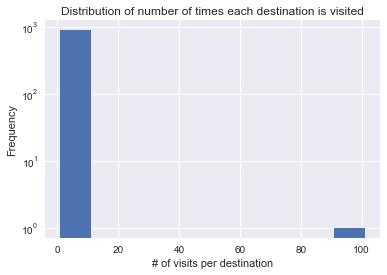

In [17]:
plt.figure()
plt.hist(uniquePoints, log=True)
plt.title('Distribution of number of times each destination is visited')
plt.xlabel('# of visits per destination')
plt.ylabel('Frequency')
plt.show()

Evidently, most of them are visited very few times. Some however are visited quite heavily. The histogram is not very helpful, so we will need to dig further. For simplicity, we will add an id column to the orignal dataset for each unique coordinate pair:

In [18]:
dataNoDups = data.drop_duplicates()[['Longitude', 'Latitude']].reset_index(drop=True).reset_index()
dataNoDups['index'] = dataNoDups['index'] + 1
data = pd.merge(data, dataNoDups,
                  how='left', left_on=['Longitude','Latitude'], right_on = ['Longitude','Latitude'])

# data = pd.merge(data, data.drop_duplicates()[['Longitude', 'Latitude']].reset_index(drop=True).reset_index(),
#                   how='left', left_on=['Longitude','Latitude'], right_on = ['Longitude','Latitude'])
data.rename(columns={'index':'LocationID'}, inplace=True)

In [19]:
data.head(10)

,y,x,Longitude,Latitude,LocationID
0,0.397150,2.113629,121.236463,22.715490,1
1,0.397150,2.113629,121.236463,22.715490,1
2,0.397150,2.113629,121.236463,22.715490,1
3,0.397150,2.113629,121.236463,22.715490,1
4,0.397150,2.113629,121.236463,22.715490,1
5,0.397150,2.113629,121.236463,22.715490,1
6,0.397150,2.113629,121.236463,22.715490,1
7,0.397150,2.113629,121.236463,22.715490,1
8,0.967562,-0.099246,-5.692702,55.340935,2
9,0.061841,-1.333110,-76.466409,3.537070,3


From there, it is easier to see how often the traveler returns to the original point and other repeated destinations:

In [20]:
dataMultipleVisits = data.groupby('LocationID')['LocationID'].count()
dataMultipleVisits = dataMultipleVisits[dataMultipleVisits > 1]
print(f'Number of places visited multiple times: {len(dataMultipleVisits)}\n')
print(dataMultipleVisits)

Number of places visited multiple times: 13

LocationID
1     101
3       2
4       2
8       2
9       2
11      2
12      2
14      2
15      2
17      2
18      2
19      2
22      2
Name: LocationID, dtype: int64


We can try to deduce the actual time scale of the recordings if we can identify any type of recurrence in the visit of the repeated locations. For this, we will consider all non-repeated locations to be equal, and plot the time at which each repeated location is visited. 

The idea of such a plot is to determine wheter there are identifiable patterns to the trips. For example, if the same place is visited every 365 measures, it might be that the measures are taken every day and the traveler returns home for a yearly holiday (every 12 measures would suggest monthly intervals and so on).

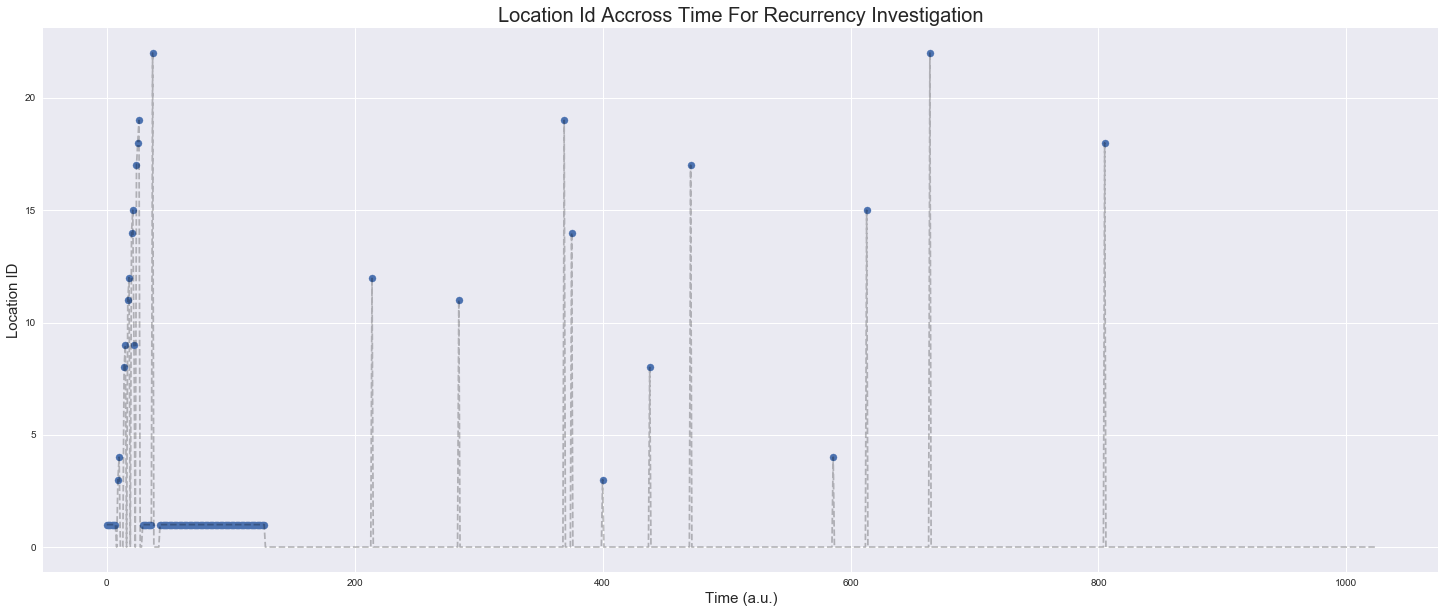

In [21]:
dataRecurrence = data['LocationID'].reset_index()
dataRecurrence[~dataRecurrence['LocationID'].isin(dataMultipleVisits.index)] = 0

dataRecurrence[data['LocationID'].isin(dataMultipleVisits.index)].plot(figsize=(25, 10), kind='scatter', s=50,
                                                                           x='index', y='LocationID')
plt.plot(dataRecurrence.index, dataRecurrence.LocationID, 'k--', alpha=0.25)
plt.title('Location ID accross time for recurrency investigation'.title(), size=20)
plt.ylabel('Location ID', size=15)
plt.xlabel('Time (a.u.)', size=15)


plt.show()

Unfortunately, there are no easily identifiable patterns in the data other than location one is heavily visited at the beginning of the recordings. Further analysis would need to be done to have a better understanding of the acquistion rate. As it is, weekly measures seems to be the safest guess.

# Potential Additional Analysis

## Geographical distribution

We can look at the density of travel in different areas of the world by applying different space distributions:

In [22]:
gmin, gmax, dg = (20, 50, 5)
gridsz = np.arange(gmin, gmax+dg, dg)
G = len(gridsz)

fig = plt.figure(figsize=(15, 8))

ax = fig.add_axes(plt.axes(projection=ccrs.PlateCarree()))
ax.add_feature(borders, edgecolor='black', linewidth=0.75)
ax.coastlines()
newbins = ax.hexbin(data.Longitude, data.Latitude, mincnt=1, bins='log', cmap='bwr', gridsize=10, alpha=0.5)
cax, kw = matplotlib.colorbar.make_axes(ax, location='bottom', pad=0.05)
cbar = fig.colorbar(newbins, cax=cax, extend='both',**kw)
# cbar.remove()


def animate(i):
    gsize = gridsz[i]
    ax.set_title(f'Grid Size  = {gsize}')
    
    clear_output(wait=True)
    print(f'Currently rendered: {(i+1)/G*100:.2f}%')

    global newbins, cax
    newbins.remove()
    cax.cla()    
    
    newbins = ax.hexbin(data.Longitude, data.Latitude, mincnt=1, bins='log', cmap='coolwarm', gridsize=gsize, alpha=0.75)
    cbar=fig.colorbar(newbins, cax=cax,**kw)
    cax.set_title('# of travels', y=-2)

    return newbins,

anim = animation.FuncAnimation(fig, animate, frames=G, interval=1500, blit=False)
anim.save('travelHistory_grid.mp4')
plt.close()

Currently rendered: 100.00%


In [23]:
HTML("""
    <video alt='Video could not be displayed on your computer' controls autoplay loop>
        <source src="travelHistory_grid.mp4" type="video/mp4">
    </video>
""")

## Clustering analysis
We can look for clusters of travel. For now, we will do this thinking of the world as a 2D plane. With more time, we can extend this to a 3D projection. We will  use a relatively simple and popular clustering method, kmeans clustering.

Kmeans clustering requires one to select the number of clusters $k$ to be used before hand. An intuitive method to find a good candidate is the *elbow method*: the optimal number of clusters is chosen based on where the plot of clustering score vs number of clusters seems to bend significantly:

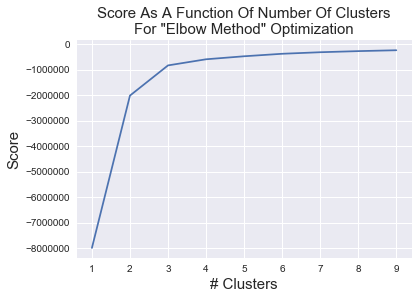

In [24]:
dataKmeans = data[['Longitude', 'Latitude']]
Ks = range(1, 10)
km = [KMeans(n_clusters=i) for i in Ks]
score = [km[i].fit(dataKmeans).score(dataKmeans) for i in range(len(km))]

plt.figure()
plt.plot(Ks, score)
plt.title('Score as a function of number of clusters\nfor "elbow method" optimization'.title(), size=15)
plt.ylabel('Score', size=15)
plt.xlabel('# Clusters', size=15)
plt.show()

While 3 is a good candidate, so might be 7 and 7 gives rise to more interesting divisions of space, so 7 will be used:

In [25]:
kmeans = KMeans(init='k-means++', n_clusters=7)
kmeans.fit(data[['Longitude', 'Latitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

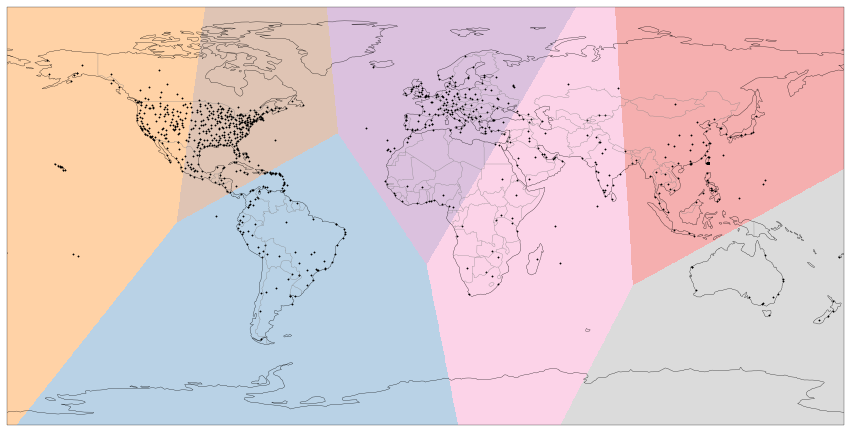

In [31]:
# Plot the decision boundary. For that, we will assign a color to each
h = 0.2
x_min, x_max = (-180, 180)
y_min, y_max = (-90, 90)
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
fig = plt.figure(figsize=(15, 18))
ax = plt.axes(projection=ccrs.PlateCarree())
# ax.stock_img()
ax.coastlines();
borders = cfeature.BORDERS
ax.add_feature(borders, edgecolor='gray')

ax.scatter(data.Longitude, data.Latitude, transform=ccrs.PlateCarree(),
           c='black', s=2)
ax.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin='lower', alpha=0.35, cmap='Set1')

plt.show()
fig.savefig('GeoCluster.JPG', bbox_inches = 'tight',
    pad_inches = 0)

We can add the travel cluster to every data point of the dataset:

In [27]:
data['cluster'] = kmeans.predict(dataKmeans)
data.to_csv('dataGeo.csv')
data.head(10)

,y,x,Longitude,Latitude,LocationID,cluster
0,0.397150,2.113629,121.236463,22.715490,1,0
1,0.397150,2.113629,121.236463,22.715490,1,0
2,0.397150,2.113629,121.236463,22.715490,1,0
3,0.397150,2.113629,121.236463,22.715490,1,0
4,0.397150,2.113629,121.236463,22.715490,1,0
5,0.397150,2.113629,121.236463,22.715490,1,0
6,0.397150,2.113629,121.236463,22.715490,1,0
7,0.397150,2.113629,121.236463,22.715490,1,0
8,0.967562,-0.099246,-5.692702,55.340935,2,2
9,0.061841,-1.333110,-76.466409,3.537070,3,1


# Future directions

Time:
* Probaiblity of moving out of travel cluster vs remainng withing cluster
* If leaving/staying cluster, where is one more likely to go?
* Probability of doing long travels vs short travels
* Paterns of long vs short travels (e.g. 3 short ones followed by one long travel)

Clustering:
* It would be great to first perform clustering on the 3D projections. As it is, the pacific ocean is cut in half and disconnected
* Use a distance measure differnt from Euclidian distance. Euclidian distance on the globe can lead to misleading results

Network analysis (networkx library):
* Look at important ravel nodes, bridges
* Look at geographic and temporal connectivity (directed, weighted, etc)